In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!pip install numpy pandas matplotlib seaborn opencv-python tensorflow keras scikit-learn


In [17]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from glob import glob

# Define dataset paths
first_print_path = r"/content/drive/MyDrive/Colab Notebooks/Collab Datasets/Qrcode dataset/First Print"
second_print_path = r"/content/drive/MyDrive/Colab Notebooks/Collab Datasets/Qrcode dataset/Second Print"
# Get all image file paths
first_print_images = glob(os.path.join(first_print_path, "*"))
second_print_images = glob(os.path.join(second_print_path, "*"))

# Print dataset statistics
print(f"Number of first print images: {len(first_print_images)}")
print(f"Number of second print images: {len(second_print_images)}")


Number of first print images: 100
Number of second print images: 100


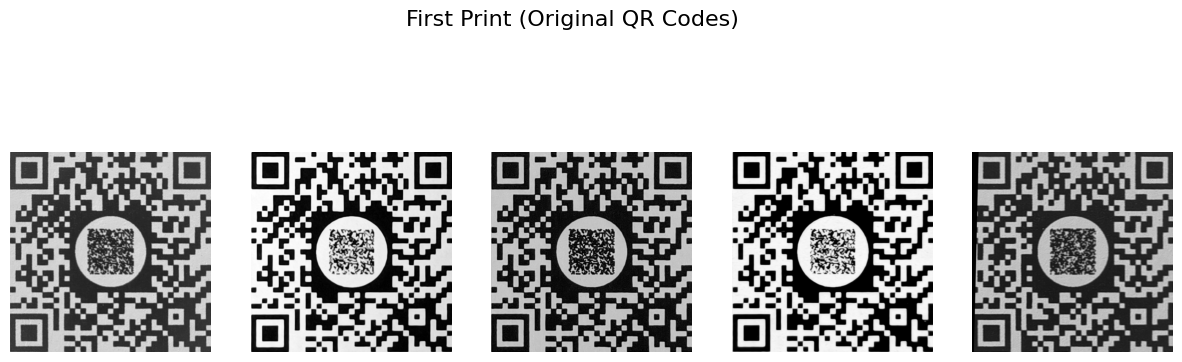

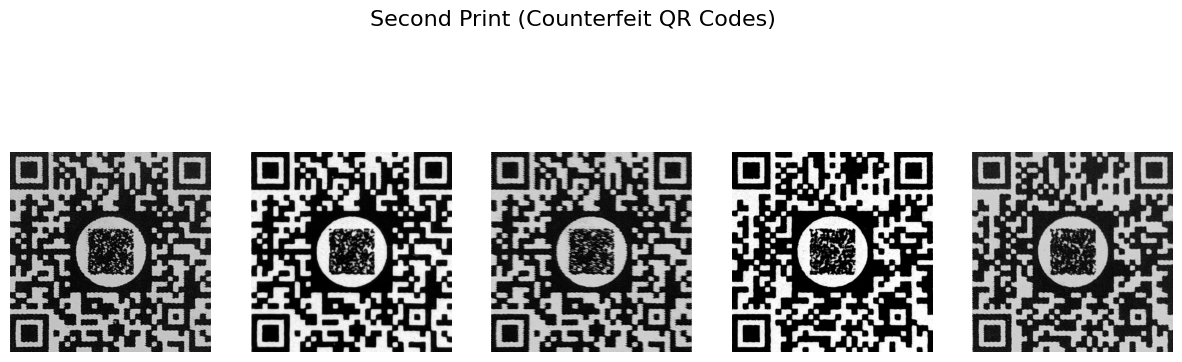

In [18]:
# Function to load and display images
def show_images(images, title, num_samples=5):
    plt.figure(figsize=(15, 5))
    for i in range(num_samples):
        img = cv2.imread(images[i])  # Load image
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Convert from BGR to RGB
        plt.subplot(1, num_samples, i + 1)
        plt.imshow(img)
        plt.axis("off")
    plt.suptitle(title, fontsize=16)
    plt.show()

# Show first print images
show_images(first_print_images, "First Print (Original QR Codes)")

# Show second print images
show_images(second_print_images, "Second Print (Counterfeit QR Codes)")


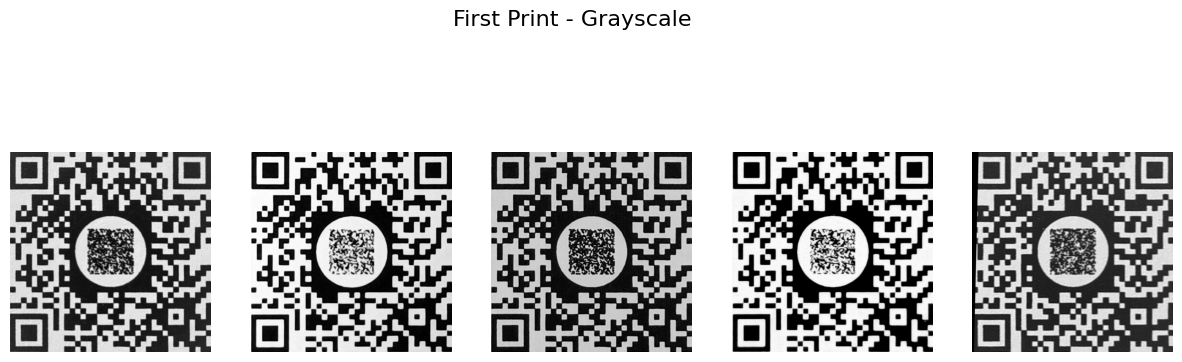

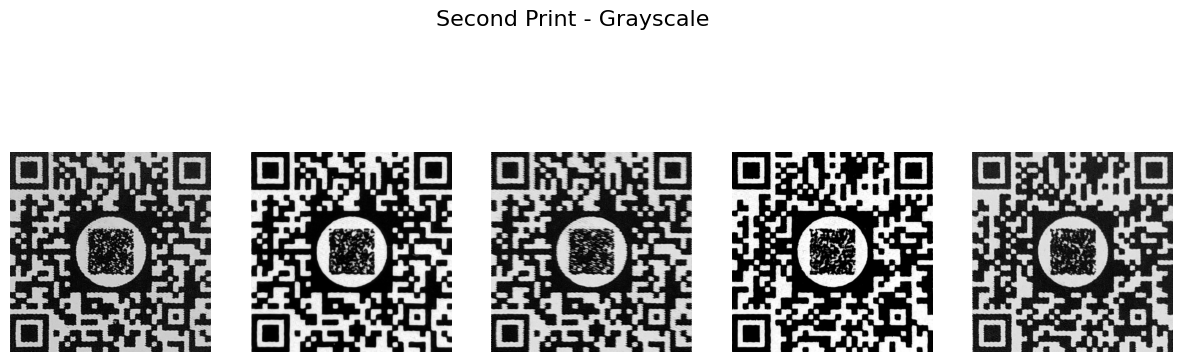

In [19]:
def show_gray_images(images, title, num_samples=5):
    plt.figure(figsize=(15, 5))
    for i in range(num_samples):
        img = cv2.imread(images[i], cv2.IMREAD_GRAYSCALE)  # Load in grayscale
        plt.subplot(1, num_samples, i + 1)
        plt.imshow(img, cmap="gray")
        plt.axis("off")
    plt.suptitle(title, fontsize=16)
    plt.show()

# Show grayscale versions of images
show_gray_images(first_print_images, "First Print - Grayscale")
show_gray_images(second_print_images, "Second Print - Grayscale")


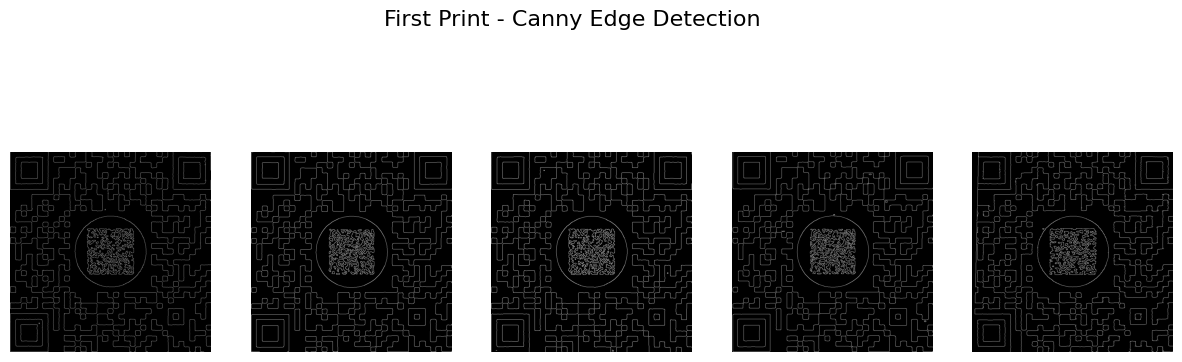

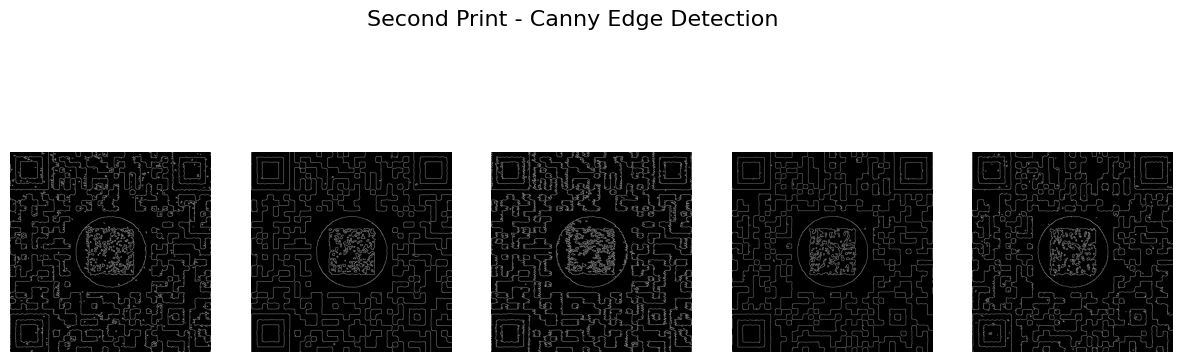

In [20]:
def show_canny_edges(images, title, num_samples=5):
    plt.figure(figsize=(15, 5))
    for i in range(num_samples):
        img = cv2.imread(images[i], cv2.IMREAD_GRAYSCALE)  # Load in grayscale
        edges = cv2.Canny(img, 100, 200)  # Apply Canny Edge Detection
        plt.subplot(1, num_samples, i + 1)
        plt.imshow(edges, cmap="gray")
        plt.axis("off")
    plt.suptitle(title, fontsize=16)
    plt.show()

# Apply Canny Edge Detection
show_canny_edges(first_print_images, "First Print - Canny Edge Detection")
show_canny_edges(second_print_images, "Second Print - Canny Edge Detection")


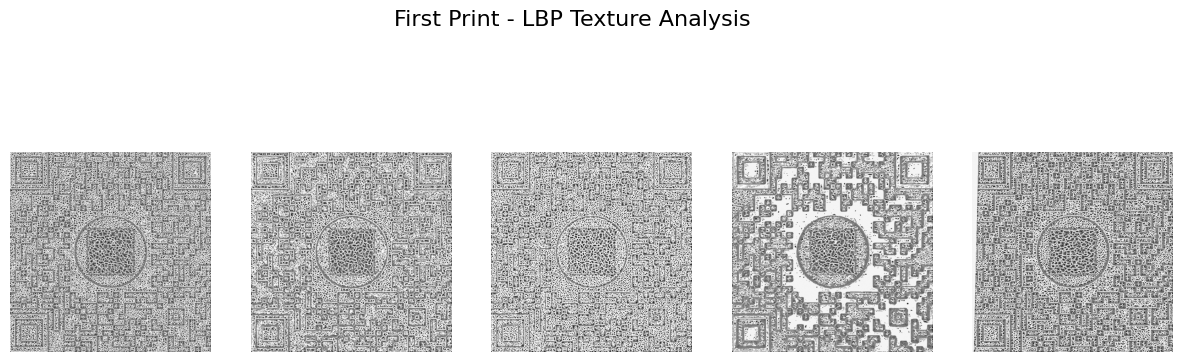

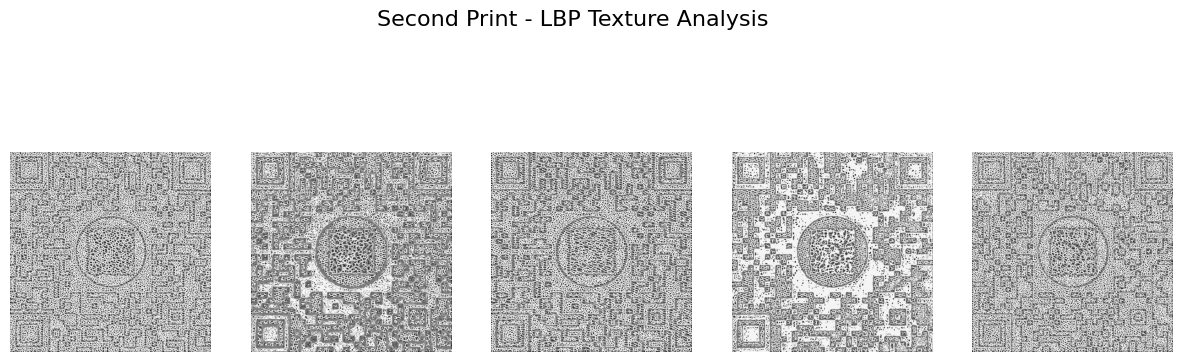

In [21]:
from skimage.feature import local_binary_pattern

def show_lbp_images(images, title, num_samples=5, radius=3, n_points=8*3):
    plt.figure(figsize=(15, 5))
    for i in range(num_samples):
        img = cv2.imread(images[i], cv2.IMREAD_GRAYSCALE)  # Load in grayscale
        lbp = local_binary_pattern(img, n_points, radius, method="uniform")  # Apply LBP
        plt.subplot(1, num_samples, i + 1)
        plt.imshow(lbp, cmap="gray")
        plt.axis("off")
    plt.suptitle(title, fontsize=16)
    plt.show()

# Apply LBP Feature Extraction
show_lbp_images(first_print_images, "First Print - LBP Texture Analysis")
show_lbp_images(second_print_images, "Second Print - LBP Texture Analysis")


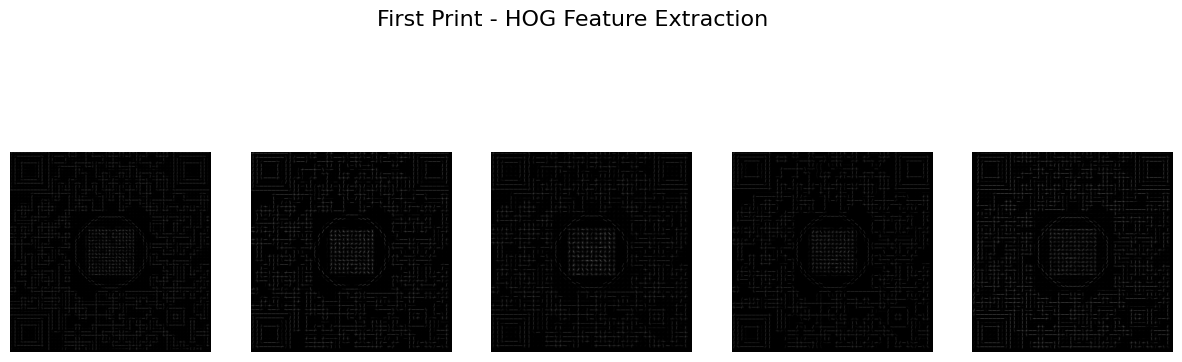

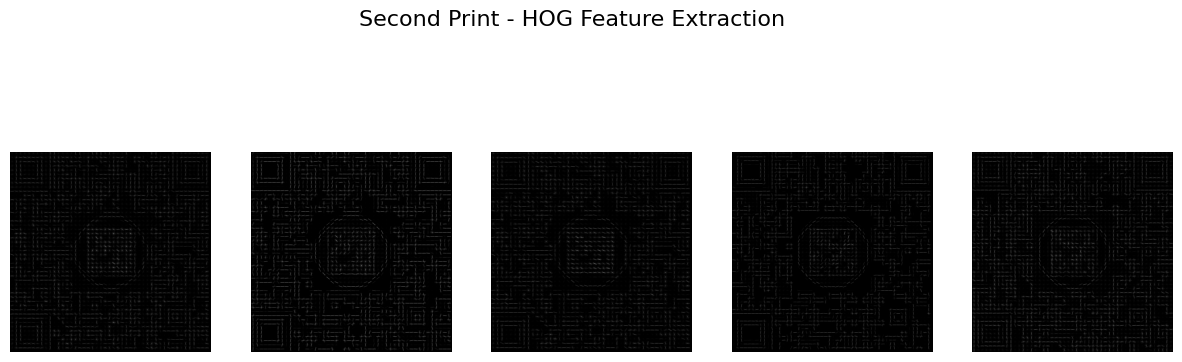

In [22]:
from skimage.feature import hog

def show_hog_images(images, title, num_samples=5):
    plt.figure(figsize=(15, 5))
    for i in range(num_samples):
        img = cv2.imread(images[i], cv2.IMREAD_GRAYSCALE)  # Load in grayscale
        hog_features, hog_image = hog(img, pixels_per_cell=(16, 16), cells_per_block=(2, 2),
                                      orientations=9, visualize=True, block_norm="L2-Hys")
        plt.subplot(1, num_samples, i + 1)
        plt.imshow(hog_image, cmap="gray")
        plt.axis("off")
    plt.suptitle(title, fontsize=16)
    plt.show()

# Apply HOG Feature Extraction
show_hog_images(first_print_images, "First Print - HOG Feature Extraction")
show_hog_images(second_print_images, "Second Print - HOG Feature Extraction")


In [24]:
import numpy as np
import os
import cv2
from skimage.feature import hog, local_binary_pattern
from glob import glob
from concurrent.futures import ThreadPoolExecutor

# Define folder paths
first_print_folder = r"/content/drive/MyDrive/Colab Notebooks/Collab Datasets/Qrcode dataset/First Print"
second_print_folder = r"/content/drive/MyDrive/Colab Notebooks/Collab Datasets/Qrcode dataset/Second Print"

# Get all image file paths
first_print_paths = glob(os.path.join(first_print_folder, "*.png"))  # Adjust extension if needed
second_print_paths = glob(os.path.join(second_print_folder, "*.png"))
all_image_paths = first_print_paths + second_print_paths

# Assign labels: 0 for first print, 1 for second print
labels = [0] * len(first_print_paths) + [1] * len(second_print_paths)

def extract_features(image_path):
    img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    img = cv2.resize(img, (128, 128))  # Resize to speed up processing

    # Extract LBP Features
    lbp = local_binary_pattern(img, P=16, R=2, method="uniform")  # Reduce P & R for faster processing
    lbp_hist, _ = np.histogram(lbp.ravel(), bins=np.arange(19), density=True)  # 18 bins instead of 26

    # Extract HOG Features (Reduce orientations and increase cell size for speed)
    hog_features, _ = hog(img, pixels_per_cell=(32, 32), cells_per_block=(2, 2),
                          orientations=6, visualize=True, block_norm="L2-Hys")

    # Extract Edge Features (Canny)
    edges = cv2.Canny(img, 100, 200)
    edge_hist, _ = np.histogram(edges.ravel(), bins=10, density=True)

    return np.hstack([lbp_hist, hog_features, edge_hist])

# Run feature extraction in parallel
with ThreadPoolExecutor() as executor:
    X = list(executor.map(extract_features, all_image_paths))

# Convert to NumPy arrays
X = np.array(X)
y = np.array(labels)

# Print dataset shape
print(f"Feature matrix shape: {X.shape}")
print(f"Labels shape: {y.shape}")


Feature matrix shape: (200, 244)
Labels shape: (200,)


In [25]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report

# Split dataset into 80% training and 20% testing
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Train a Random Forest Classifier
clf = RandomForestClassifier(n_estimators=100, random_state=42)
clf.fit(X_train, y_train)

# Predictions
y_pred = clf.predict(X_test)

# Evaluate Model
accuracy = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred)

# Print results
print(f"✅ Model Accuracy: {accuracy:.4f}")
print("\n🔍 Classification Report:\n", report)


✅ Model Accuracy: 0.9500

🔍 Classification Report:
               precision    recall  f1-score   support

           0       0.95      0.95      0.95        20
           1       0.95      0.95      0.95        20

    accuracy                           0.95        40
   macro avg       0.95      0.95      0.95        40
weighted avg       0.95      0.95      0.95        40



In [26]:
import cv2
import numpy as np
import tensorflow as tf
from tensorflow.keras.utils import to_categorical

# Set image dimensions
IMG_SIZE = 128

# Function to load and preprocess images
def load_images(image_paths, label):
    images = []
    labels = []

    for img_path in image_paths:
        img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)  # Read image in grayscale
        img = cv2.resize(img, (IMG_SIZE, IMG_SIZE))  # Resize image
        img = img / 255.0  # Normalize pixel values (0 to 1)

        images.append(img)
        labels.append(label)

    return np.array(images), np.array(labels)

# Load First Print images (Label: 0)
X_first, y_first = load_images(first_print_images, 0)

# Load Second Print images (Label: 1)
X_second, y_second = load_images(second_print_images, 1)

# Combine both datasets
X = np.concatenate((X_first, X_second), axis=0)
y = np.concatenate((y_first, y_second), axis=0)

# Reshape X to fit CNN input (add a channel dimension)
X = X.reshape(-1, IMG_SIZE, IMG_SIZE, 1)  # Shape: (samples, 128, 128, 1)

# Convert labels to categorical (for CNN)
y = to_categorical(y, num_classes=2)

# Print dataset shape
print(f"✅ Dataset loaded: {X.shape[0]} images of size {IMG_SIZE}x{IMG_SIZE}")
print(f"✅ Labels shape: {y.shape}")


✅ Dataset loaded: 200 images of size 128x128
✅ Labels shape: (200, 2)


In [39]:
import os
import numpy as np
import cv2
from sklearn.model_selection import train_test_split

# Define image directory paths
first_print_dir = "/content/drive/MyDrive/Colab Notebooks/Collab Datasets/Qrcode dataset/First Print"
second_print_dir = "/content/drive/MyDrive/Colab Notebooks/Collab Datasets/Qrcode dataset/Second Print"

# Initialize lists
X = []
y = []

# Load First Print images (Label: 0)
for img_name in os.listdir(first_print_dir):
    img_path = os.path.join(first_print_dir, img_name)
    img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)  # Load as grayscale
    img = cv2.resize(img, (128, 128))  # Resize to 128x128
    X.append(img)
    y.append(0)  # Label for first print

# Load Second Print images (Label: 1)
for img_name in os.listdir(second_print_dir):
    img_path = os.path.join(second_print_dir, img_name)
    img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)  # Load as grayscale
    img = cv2.resize(img, (128, 128))  # Resize to 128x128
    X.append(img)
    y.append(1)  # Label for second print

# Convert lists to NumPy arrays
X = np.array(X, dtype=np.float32) / 255.0  # Normalize pixel values (0-1)
y = np.array(y)

# Reshape X to match CNN input format (samples, height, width, channels)
X = X.reshape(-1, 128, 128, 1)

# Split dataset into training (80%) and testing (20%) sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Print dataset shapes
print(f"✅ X_train shape: {X_train.shape}")
print(f"✅ X_test shape: {X_test.shape}")
print(f"✅ y_train shape: {y_train.shape}")
print(f"✅ y_test shape: {y_test.shape}")


✅ X_train shape: (160, 128, 128, 1)
✅ X_test shape: (40, 128, 128, 1)
✅ y_train shape: (160,)
✅ y_test shape: (40,)


In [40]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout

# Define CNN architecture
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(128, 128, 1)),
    MaxPooling2D(pool_size=(2, 2)),

    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),

    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(2, activation='softmax')  # Binary classification (2 classes)
])

# Compile the model
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Print model summary
model.summary()


Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_4 (Conv2D)                    │ (None, 126, 126, 32)        │             320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_4 (MaxPooling2D)       │ (None, 63, 63, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ (None, 61, 61, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_5 (MaxPooling2D)       │ (None, 30, 30, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_2 (Flatten)                  │ (None, 57600)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_10 (Dense)                     │ (None, 128)                 │       7,372,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_4 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_11 (Dense)                     │ (None, 2)                   │             258 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 7,392,002 (28.20 MB)

 Trainable params: 7,392,002 (28.20 MB)

 Non-trainable params: 0 (0.00 B)

In [41]:
# Train the model
history = model.fit(
    X_train, y_train,  # Training data
    validation_data=(X_test, y_test),  # Validation data
    epochs=20,  # Number of training cycles
    batch_size=16,  # Number of images per batch
    verbose=1  # Display training progress
)


Epoch 1/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 8s 462ms/step - accuracy: 0.5080 - loss: 0.9251 - val_accuracy: 0.9250 - val_loss: 0.5472
Epoch 2/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 10s 536ms/step - accuracy: 0.6937 - loss: 0.5918 - val_accuracy: 0.8750 - val_loss: 0.3227
Epoch 3/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 10s 497ms/step - accuracy: 0.8509 - loss: 0.4089 - val_accuracy: 0.9750 - val_loss: 0.2360
Epoch 4/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 5s 460ms/step - accuracy: 0.9501 - loss: 0.3171 - val_accuracy: 1.0000 - val_loss: 0.1531
Epoch 5/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 5s 496ms/step - accuracy: 0.9594 - loss: 0.2109 - val_accuracy: 0.8750 - val_loss: 0.1624
Epoch 6/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 5s 486ms/step - accuracy: 0.9684 - loss: 0.1358 - val_accuracy: 0.9750 - val_loss: 0.0760
Epoch 7/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 4s 382ms/step - accuracy: 0.9249 - loss: 0.1431 - val_accuracy: 1.0000 - val_loss: 0.0630
Epoch 8/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 4s 375ms/step - accuracy: 0.9713 - loss: 0.0852 - val_accuracy: 

In [42]:
# Evaluate the model on test data
test_loss, test_accuracy = model.evaluate(X_test, y_test, verbose=1)

# Print results
print(f"Test Accuracy: {test_accuracy * 100:.2f}%")
print(f"Test Loss: {test_loss:.4f}")


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 174ms/step - accuracy: 1.0000 - loss: 0.0096
Test Accuracy: 100.00%
Test Loss: 0.0090


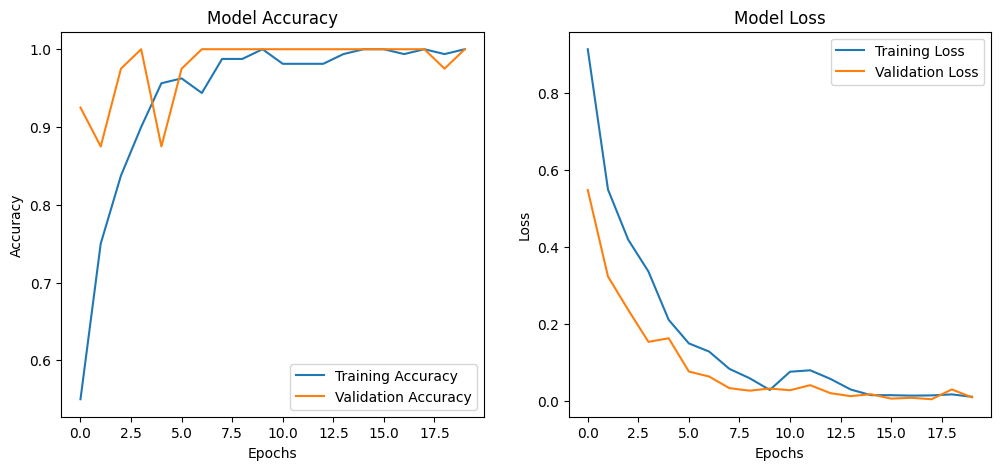

In [43]:
import matplotlib.pyplot as plt

# Plot training & validation accuracy
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Plot training & validation loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()


In [44]:
for i in range(len(history.history['accuracy'])):
    print(f"Epoch {i+1}: Train Acc: {history.history['accuracy'][i]:.4f}, "
          f"Val Acc: {history.history['val_accuracy'][i]:.4f}, "
          f"Train Loss: {history.history['loss'][i]:.4f}, "
          f"Val Loss: {history.history['val_loss'][i]:.4f}")


Epoch 1: Train Acc: 0.5500, Val Acc: 0.9250, Train Loss: 0.9127, Val Loss: 0.5472
Epoch 2: Train Acc: 0.7500, Val Acc: 0.8750, Train Loss: 0.5485, Val Loss: 0.3227
Epoch 3: Train Acc: 0.8375, Val Acc: 0.9750, Train Loss: 0.4183, Val Loss: 0.2360
Epoch 4: Train Acc: 0.9000, Val Acc: 1.0000, Train Loss: 0.3356, Val Loss: 0.1531
Epoch 5: Train Acc: 0.9563, Val Acc: 0.8750, Train Loss: 0.2103, Val Loss: 0.1624
Epoch 6: Train Acc: 0.9625, Val Acc: 0.9750, Train Loss: 0.1490, Val Loss: 0.0760
Epoch 7: Train Acc: 0.9438, Val Acc: 1.0000, Train Loss: 0.1278, Val Loss: 0.0630
Epoch 8: Train Acc: 0.9875, Val Acc: 1.0000, Train Loss: 0.0830, Val Loss: 0.0329
Epoch 9: Train Acc: 0.9875, Val Acc: 1.0000, Train Loss: 0.0587, Val Loss: 0.0264
Epoch 10: Train Acc: 1.0000, Val Acc: 1.0000, Train Loss: 0.0282, Val Loss: 0.0319
Epoch 11: Train Acc: 0.9812, Val Acc: 1.0000, Train Loss: 0.0755, Val Loss: 0.0275
Epoch 12: Train Acc: 0.9812, Val Acc: 1.0000, Train Loss: 0.0792, Val Loss: 0.0407
Epoch 13: Tra

In [45]:
import numpy as np

random_samples = np.random.randint(0, len(X_test), 5)  # Select 5 random test samples
for i in random_samples:
    img = X_test[i]
    label = y_test[i]

    prediction = model.predict(np.expand_dims(img, axis=0))  # Predict single image
    predicted_label = np.argmax(prediction)  # Get class with highest probability

    print(f"Actual Label: {label}, Predicted Label: {predicted_label}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 206ms/step
Actual Label: 0, Predicted Label: 0
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 170ms/step
Actual Label: 1, Predicted Label: 1
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 182ms/step
Actual Label: 1, Predicted Label: 1
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step
Actual Label: 0, Predicted Label: 0
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step
Actual Label: 0, Predicted Label: 0
